# Ритейл — Анализ программы лояльности

ОПИСАНИЕ ДАННЫХ:\
Датасет содержит данные о покупках в магазине строительных материалов «Строили, строили и наконец построили». \
Все покупатели могут получить доступ в магазин с использованием персональных карт. \
За 200 рублей в месяц они могут стать участниками программы лояльности. \
В программу включены скидки, специальные предложения, подарки.

ЗАДАЧИ ПРОЕКТА:\
Провести исследовательский анализ данных;\
Провести анализ программы лояльности;\
Сформулировать и проверить статистические гипотезы.\
Оценить возможности развития программы лояльности.

## Загрузка данных.
Загрузка и первичный осмотр, получение общей информации о наборах данных.

В нашем распоряжении два датасета:\
retail_dataset.csv - журнал продаж\
product_codes.csv - стоимость товара

retail_dataset.csv:

- `purchaseId` — id чека;
- `item_ID` — id товара;
- `purchasedate` — дата покупки;
- `Quantity` — количество товара;
- `CustomerID` — id покупателя;
- `ShopID` — id магазина;
- `loyalty_program` — участвует ли покупатель в программе лояльности;

product_codes.csv:

- `productID` — id товара;
- `price_per_one` — стоимость одной единицы товара;

In [329]:
#загрузим нужные библиотеки
import pandas as pd
import numpy as np
from numpy import mean
import math as mth
import datetime as dt
import seaborn as sns
import scipy.stats as st
import plotly.express as px
import matplotlib.pyplot as plt
from plotly import graph_objects as go

In [330]:
#загрузим данные
try:
   product, retail = (
    pd.read_csv("C:\\Users\\kirio\\OneDrive\\Рабочий стол\\ЯПрактикум\\14_Выпускной Проект\\product_codes.csv", sep=','), #стоимость товара
    pd.read_csv('C:\\Users\\kirio\\OneDrive\\Рабочий стол\\ЯПрактикум\\14_Выпускной Проект\\retail_dataset.csv', sep=',') #журнал продаж
)
except:
   product, retail = (
    pd.read_csv('https://code.s3.yandex.net/datasets/product_codes.csv', sep=','), #стоимость товара
    pd.read_csv('https://code.s3.yandex.net/datasets/product_codes.csv', sep=',') #журнал продаж
)

In [331]:
#общая информация о наборе данных в журнале продаж
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


В датасете журнала продаж 105335 строк, 7 столбцов. Три типа данных: object, float64 и int64. В столбце 'CustomerID' есть пропущенные значения. 

In [332]:
#общая информация о наборе данных стоимости товара
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


В датасете стоимости товара 9969 строк, два столбца. Два типа данных: object и float64. Пропусков нет.

## Предобработка данных.
Исследованее пропущенных значений. Преобразование типов данных. Переименование и добавление столбцов.  Удаление дубликатов. 

### Начнем с журнала продаж:

In [333]:
#переименуем названия столбцов
retail = retail.rename(
   columns={
       'purchaseid': 'purchase_id',\
       'item_ID': 'item_id',\
       'Quantity': 'quantity',\
       'purchasedate': 'purchase_date',\
       'CustomerID': 'customer_id',\
       'ShopID': 'shop_id'\
   }
)

In [334]:
#количество пропусков в столбце customer_id
retail['customer_id'].isna().sum()

36210

In [335]:
# % пропусков
pd.DataFrame(round(retail.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
purchase_id,0.000000
item_id,0.000000
quantity,0.000000
purchase_date,0.000000
customer_id,34.000000
shop_id,0.000000
loyalty_program,0.000000


In [336]:
#срез по событиям незарегистрированных пользователей не участвующих в программе лояльности 
retail.query('loyalty_program == 0.0')['customer_id'].isna().sum()

36210

Треть (34%) пользователей совершили покупки без регистрации (количество: 36210) и все они не участвуют в программе лояльности.

In [337]:
#количество событий в разрезе программы лояльности
retail['loyalty_program'].value_counts()

0.0    81493
1.0    23842
Name: loyalty_program, dtype: int64

In [338]:
#выведем количество уникальных пользователей по группе лояльности
retail.groupby('loyalty_program').agg({'customer_id':'nunique'})

,customer_id
loyalty_program,
0.0,1162
1.0,587


В нашем исследовании гипотезы основаны на следующих метриках: средний чек, среднее количество покупок и кумулятивная сумма денег которую  клиент в среднем принёс компании.\
Все они рассчитываются на каждого клиента, в случае замены на "заглушки", отсутствующие значения могут быть интерпретированы как действия одного клиента с множеством покупок.\
Удалить или "заглушить" 34% датасета неприемлемо - исказятся данные клиентов не участвующих в программе лояльности.\
Небходимо присвоить уникальные customer_id, заменив пропуски на purchase_id, они уникальны как покупка.

In [339]:
#запишем в новую переменную датасет, удалив строки с пропусками для будущих вычислений  
retail_cut = retail.dropna().reset_index(drop=True)
retail_cut.shape

(69125, 7)

In [340]:
#заменим пропуски на уникальные purchase_id
retail['customer_id'] = retail['customer_id'].fillna(retail['purchase_id'])
retail.shape

(105335, 7)

In [341]:
#выведем количество уникальных пользователей по группе лояльности
retail.groupby('loyalty_program').agg({'customer_id':'nunique'})

,customer_id
loyalty_program,
0.0,1910
1.0,587


In [342]:
#преобразуем типы данных в столбцах loyalty_program и purchase_date 
retail['loyalty_program'] = retail['loyalty_program'].astype('int')
retail['purchase_date'] = pd.to_datetime(retail['purchase_date'])

In [343]:
#добавим новые столбцы с днями недели и неделями
retail['weekday'] = retail['purchase_date'].dt.weekday
retail['week'] = retail['purchase_date'].dt.isocalendar().week

In [344]:
#количество явных дубликатов в датафрейме
retail.duplicated().sum()

1033

In [345]:
#количество строк
retail.shape

(105335, 9)

In [346]:
#удалим из датафрейма строки с дубликатами, оставив только первые вхождения: будем считать, что верные идентификаторы встречаются первыми
retail = retail.drop_duplicates(keep='first').reset_index(drop=True)

In [347]:
#количество строк после удаления дубликатов
retail.shape

(104302, 9)

### Перейдем к данным стоимости товаров:

In [348]:
#переименуем название столбца
product = product.rename(columns={'productID': 'item_id', 'price_per_one':'price'})

In [349]:
#количество явных дубликатов в датафрейме
product.duplicated().sum()

0

Набор данных достаточен. Данные прошли предобработку и соответствуют необходимому уровню качества для дальнейшего интеллектуального анализа и проверке гипотез.


## Исследовательский анализ данных (EDA).
Выявление аномалий и выбросов. Группировка по лояльности и значимым признакам. Расчет долей, среднего чека, кумулятивной средней выручки лояльных покупателей относительно остальных. Поиск корреляций и особенностей. Анализ категорий по дням недели и неделям, за весь период. Визуализация распределения данных и результатов исследований с помощью графиков и диаграмм. Промежуточные выводы.

In [350]:
#первые строки журнала продаж
retail.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,weekday,week
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0,5,49
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1,2,50
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1,2,50
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1,3,6
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1,0,7


In [351]:
#минимальная дата
retail['purchase_date'].min()

Timestamp('2016-12-01 08:26:00')

In [352]:
#максимальная дата
retail['purchase_date'].max()

Timestamp('2017-02-28 17:04:00')

Набор данных за три месяца: с 2016-12-01 по 2017-02-28

In [353]:
#количество магазинов
retail['shop_id'].nunique()

31

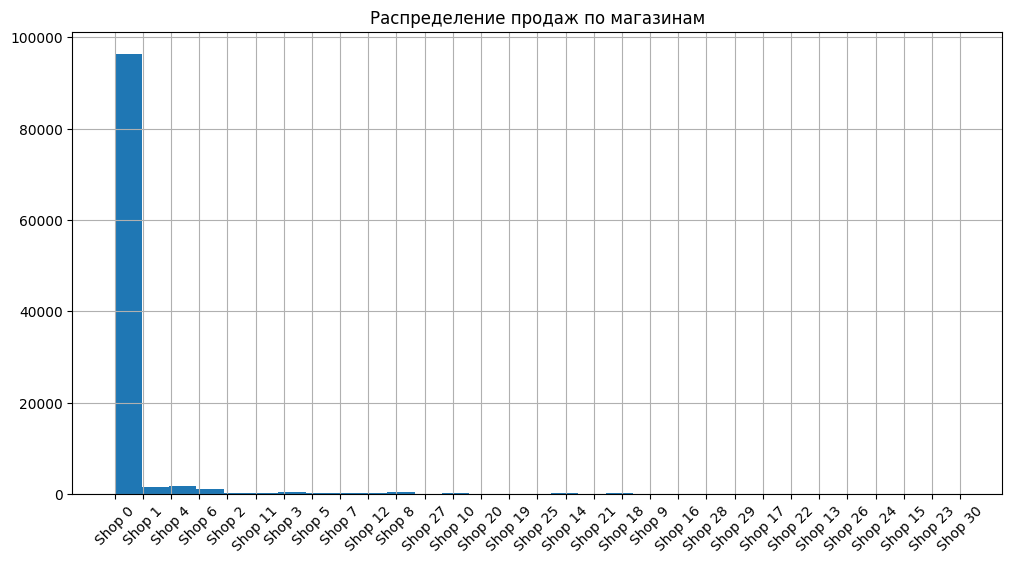

In [354]:
#для оценки характеристик распределения продаж по магазинам построим гистограмму
retail['shop_id'].hist(bins=31, figsize=(12, 6)).set(title='Распределение продаж по магазинам')
plt.xticks(rotation=45);

Доминирующее количество продаж в магазине Shop 0 указывает что данный объект, скорее всего, является онлайн-площадкой ритейла. 

In [355]:
#проверим пристствие обоих групп лояльности
retail.groupby(['shop_id','loyalty_program']).agg({'purchase_id':'count'}).sort_values(by='purchase_id', ascending=False).head()

purchase_id
shop_id loyalty_program             
Shop 0  0                      73099
        1                      23271
Shop 4  0                       1739
Shop 1  0                       1540
Shop 6  0                       1030

In [356]:
#
retail.groupby(['shop_id', 'loyalty_program']).agg({'customer_id':'nunique'}).sort_values(by='customer_id', ascending=False).head()

customer_id
shop_id loyalty_program             
Shop 0  0                       1724
        1                        584
Shop 4  0                         43
Shop 1  0                         38
Shop 8  0                         11

In [357]:
product

,item_id,price
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39
...,...,...
9964,84306,8.29
9965,90001A,4.15
9966,90118,2.46
9967,DOT,172.62


In [363]:
product.groupby('item_id')['price'].count().sort_values(ascending=False)

item_id
DOT       174
M          59
S          29
POST       15
D          13
         ... 
85018C      1
85018D      1
85019B      1
47420       1
m           1
Name: price, Length: 3159, dtype: int64

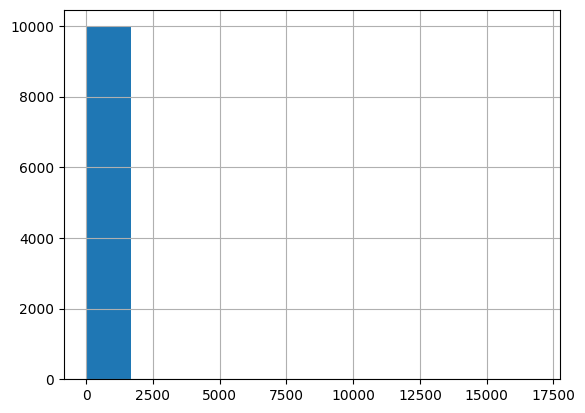

In [ ]:
product['price'].hist();

In [ ]:
#построим столбчатую диаграмму
#plt.figure(figsize=(14, 7))
#ax = sns.barplot(x='shop_id', y='purchase_id', data=retail_cut, estimator=count).set(title='Категориальное количество объектов общественного питания Москвы')
#plt.xticks(rotation=45);


In [ ]:
#минимальная дата привлечения
#profiles['dt'].min()

#retail['customer_id'].unique().sum()

# преобразование данных о времени
#costs['dt'] = pd.to_datetime(costs['dt']).dt.date

#Год выхода игр 'year_of_release' и оценки критиков 'critic_score' переведем из вещественного типа в целочисленный
#data['year_of_release'] = data['year_of_release'].astype('int')
#data['critic_score'] = data['critic_score'].astype('int')

#и приведем к вещественному типу 'object'
#data['user_score'] = data['user_score'].astype('float')

#удалим из самого датафрейма строки с явными дубликатами, оставив только первые вхождения: будем считать, что верные идентификаторы встречаются первыми
#data = data.drop_duplicates(subset=['name','platform'], keep='first')

In [364]:
retail.query('item_id == "21873"').head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,weekday,week
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0,5,49
7581,541104,21873,0,2017-01-13 14:29:00,541104,Shop 0,0,4,2
8572,540418,21873,1,2017-01-07 11:04:00,540418,Shop 0,0,5,1
13667,541516,21873,2,2017-01-18 17:34:00,541516,Shop 0,0,2,3
15301,541566,21873,35,2017-01-19 11:50:00,23401.0,Shop 0,1,3,3


In [ ]:
retail['customer_id'].nunique()

2497

In [ ]:
#
retail.groupby('shop_id').agg({'purchase_id':'count'}).sort_values(by='purchase_id', ascending=False).head()


,purchase_id
shop_id,
Shop 0,96370
Shop 4,1739
Shop 1,1540
Shop 6,1030
Shop 8,560


In [ ]:
product.query('item_id == "21873"')

,item_id,price_per_one
762,21873,1.25
3488,21873,3.36
4899,21873,0.42
5909,21873,1.66
7200,21873,1.63
8936,21873,3.29
9779,21873,1.06
